# CIFAR Experiments

Notebook for evaluating our models on the classic CIFAR dataset.

## Setup

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T

import time
import numpy as np
import matplotlib.pyplot as plt

from data_utils import get_CIFAR10_data

In [12]:
%load_ext autoreload
%autoreload 2

from modules import OctConv2dStackable, get_stacked_4
from modules import get_SixLayerConvNet, get_SixLayerOctConvNet
from octconv_tests import test_octconv_shapes, test_octconv_as_conv


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#231N Assignment 2

USE_GPU = True
print_every = 100

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Load CIFAR Data

The following code should download the CIFAR data automatically. If not, you can do so by navigating to the `datasets` directory and running the `$ ./get_datasets.sh` command from the command line.

In [4]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar10_train[0][0].shape

torch.Size([3, 32, 32])

## Train Vanilla Model on CIFAR

We're training a pretty vanilla six-layer convolutional network on CIFAR. Implementation details can be found in modulesStackable.py.

In [6]:
def check_accuracy(loader, model):
    """
    Checks accuracy of model on given data loader.
    Code adapted from 231N Assignment 2.
    """
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    # returns accuracy for plotting later
    return acc

In [7]:
def train_cifar(model, optimizer, scheduler=None, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    Code adapted from 231N assignment 2.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: a tuple comprising
    - a list of training losses per "print_every" iterations
    - a list of model accuracies during training per "print_every" iterations
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    losses = []
    accs = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy(loader_val, model)
                print()
                losses.append(loss.item())
                accs.append(acc)
    return losses, accs

In [8]:
vanilla_model = get_SixLayerConvNet()
vanilla_params = sum(p.numel() for p in vanilla_model.parameters() if p.requires_grad)
print("Number of parameters in vanilla model: {}".format(vanilla_params))

Number of parameters in vanilla model: 102794


In [9]:
start = time.time()
for i in range(100):
    1 + 1
end = time.time()
print(start - end)

-5.3882598876953125e-05


In [10]:
learning_rate = 5e-4
num_epochs = 10

optimizer = optim.Adam(vanilla_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

start = time.time()

losses, accs = train_cifar(vanilla_model, optimizer, epochs=num_epochs)

end = time.time()
print("Total training time: {} seconds".format(end - start))

Iteration 0, loss = 3.3670
Checking accuracy on validation set
Got 85 / 1000 correct (8.50)

Iteration 100, loss = 2.0785
Checking accuracy on validation set
Got 316 / 1000 correct (31.60)

Iteration 200, loss = 1.7093
Checking accuracy on validation set
Got 379 / 1000 correct (37.90)

Iteration 300, loss = 1.6076
Checking accuracy on validation set
Got 415 / 1000 correct (41.50)

Iteration 400, loss = 1.7668
Checking accuracy on validation set
Got 476 / 1000 correct (47.60)

Iteration 500, loss = 1.5139
Checking accuracy on validation set
Got 494 / 1000 correct (49.40)

Iteration 600, loss = 1.2505
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)

Iteration 700, loss = 1.4569
Checking accuracy on validation set
Got 540 / 1000 correct (54.00)

Iteration 0, loss = 1.2219
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)

Iteration 100, loss = 1.1229
Checking accuracy on validation set
Got 536 / 1000 correct (53.60)

Iteration 200, loss = 1.1646
Checkin

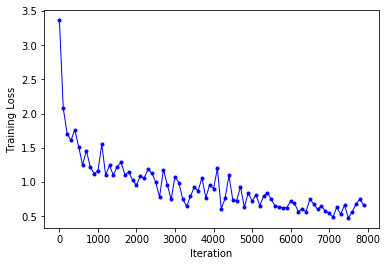

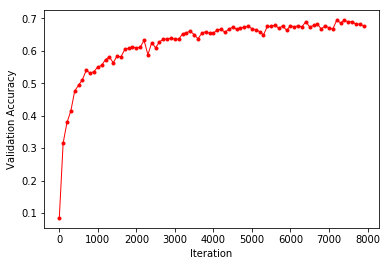

In [11]:
plt.figure()
plt.plot(np.linspace(0, (len(losses)-1)*print_every, len(losses)), np.array(losses), '-bo', lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Training Loss');

plt.figure()
plt.plot(np.linspace(0, (len(accs)-1)*print_every, len(accs)), np.array(accs), '-ro', lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
vanilla_accs = accs

## Train OctConv Model on CIFAR

We train a model with the same architecture but using OctConv models instead.

In [12]:
alphas = [0.125, 0.25, 0.5, 0.75]
hidden_channels = 32
C, H, W = cifar10_train[0][0].shape
fc_1 = 32
D_out = 10

In [14]:
octconv_model_dict = {}
losses_list = []
accs_list = []
for alpha in alphas:
    octconv_model = get_SixLayerOctConvNet(alpha, hidden_channels, C, H, W, fc_1, D_out)

    octconv_params = sum(p.numel() for p in octconv_model.parameters() if p.requires_grad)
    print("--------------------------------------------------------------------------")
    print("alpha = " + str(alpha))
    print("Number of parameters in Octconv model: {}".format(octconv_params)) 
    # Octconv doesn't reduce number of parameters, just tensor sizes

    num_epochs = 10
    learning_rate = 5e-4

    optimizer = optim.Adam(octconv_model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    start = time.time()

    losses, accs = train_cifar(octconv_model, optimizer, epochs=num_epochs)
    losses_list.append(np.array(losses))
    accs_list.append(np.array(accs))

    end = time.time()
    print("Total training time: {} seconds".format(end - start))
    
    octconv_model_dict[str(alpha)] = octconv_model

--------------------------------------------------------------------------
alpha = 0.125
Number of parameters in Octconv model: 102922
Iteration 0, loss = 2.3158
Checking accuracy on validation set


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Got 103 / 1000 correct (10.30)

Iteration 100, loss = 1.8528
Checking accuracy on validation set
Got 253 / 1000 correct (25.30)

Iteration 200, loss = 1.8629
Checking accuracy on validation set
Got 345 / 1000 correct (34.50)

Iteration 300, loss = 1.7389
Checking accuracy on validation set
Got 423 / 1000 correct (42.30)

Iteration 400, loss = 1.7571
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 500, loss = 1.5688
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Iteration 600, loss = 1.4412
Checking accuracy on validation set
Got 468 / 1000 correct (46.80)

Iteration 700, loss = 1.4477
Checking accuracy on validation set
Got 502 / 1000 correct (50.20)

Iteration 0, loss = 1.5796
Checking accuracy on validation set
Got 488 / 1000 correct (48.80)

Iteration 100, loss = 1.5262
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)

Iteration 200, loss = 1.4650
Checking accuracy on validation set
Got 532 / 1000 correct (53.20)



Got 406 / 1000 correct (40.60)

Iteration 400, loss = 1.5137
Checking accuracy on validation set
Got 442 / 1000 correct (44.20)

Iteration 500, loss = 1.5649
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Iteration 600, loss = 1.7041
Checking accuracy on validation set
Got 477 / 1000 correct (47.70)

Iteration 700, loss = 1.2794
Checking accuracy on validation set
Got 498 / 1000 correct (49.80)

Iteration 0, loss = 1.5232
Checking accuracy on validation set
Got 509 / 1000 correct (50.90)

Iteration 100, loss = 1.2735
Checking accuracy on validation set
Got 517 / 1000 correct (51.70)

Iteration 200, loss = 1.1511
Checking accuracy on validation set
Got 519 / 1000 correct (51.90)

Iteration 300, loss = 1.4186
Checking accuracy on validation set
Got 530 / 1000 correct (53.00)

Iteration 400, loss = 1.2520
Checking accuracy on validation set
Got 522 / 1000 correct (52.20)

Iteration 500, loss = 1.2133
Checking accuracy on validation set
Got 539 / 1000 correct (53.90)



Got 490 / 1000 correct (49.00)

Iteration 700, loss = 1.6486
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)

Iteration 0, loss = 1.5992
Checking accuracy on validation set
Got 496 / 1000 correct (49.60)

Iteration 100, loss = 1.2952
Checking accuracy on validation set
Got 523 / 1000 correct (52.30)

Iteration 200, loss = 1.1758
Checking accuracy on validation set
Got 544 / 1000 correct (54.40)

Iteration 300, loss = 1.2601
Checking accuracy on validation set
Got 536 / 1000 correct (53.60)

Iteration 400, loss = 1.4604
Checking accuracy on validation set
Got 541 / 1000 correct (54.10)

Iteration 500, loss = 1.2117
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)

Iteration 600, loss = 1.3408
Checking accuracy on validation set
Got 554 / 1000 correct (55.40)

Iteration 700, loss = 1.3204
Checking accuracy on validation set
Got 559 / 1000 correct (55.90)

Iteration 0, loss = 1.1745
Checking accuracy on validation set
Got 570 / 1000 correct (57.00)

It

Got 536 / 1000 correct (53.60)

Iteration 200, loss = 1.2394
Checking accuracy on validation set
Got 534 / 1000 correct (53.40)

Iteration 300, loss = 1.3214
Checking accuracy on validation set
Got 530 / 1000 correct (53.00)

Iteration 400, loss = 1.1597
Checking accuracy on validation set
Got 524 / 1000 correct (52.40)

Iteration 500, loss = 1.2519
Checking accuracy on validation set
Got 560 / 1000 correct (56.00)

Iteration 600, loss = 1.1791
Checking accuracy on validation set
Got 579 / 1000 correct (57.90)

Iteration 700, loss = 1.0662
Checking accuracy on validation set
Got 581 / 1000 correct (58.10)

Iteration 0, loss = 1.0861
Checking accuracy on validation set
Got 571 / 1000 correct (57.10)

Iteration 100, loss = 1.0299
Checking accuracy on validation set
Got 572 / 1000 correct (57.20)

Iteration 200, loss = 1.1114
Checking accuracy on validation set
Got 596 / 1000 correct (59.60)

Iteration 300, loss = 0.9896
Checking accuracy on validation set
Got 587 / 1000 correct (58.70)



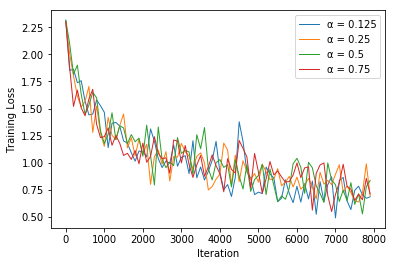

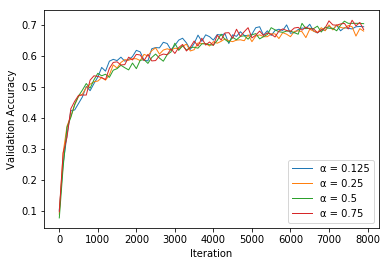

In [15]:
plt.figure()
for ii in range(len(losses_list)):
    plt.plot(np.linspace(0, (losses_list[ii].shape[0]-1)*print_every, losses_list[ii].shape[0]), losses_list[ii], lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Training Loss');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75'], loc='upper right');

plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75'], loc='lower right');

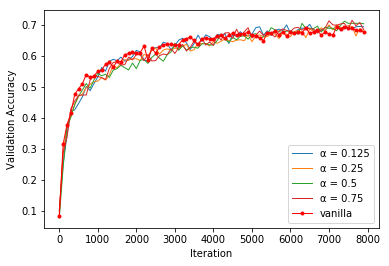

In [16]:
plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.plot(np.linspace(0, (len(vanilla_accs)-1)*print_every, len(vanilla_accs)), np.array(vanilla_accs), '-ro', lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75', 'vanilla'], loc='lower right');

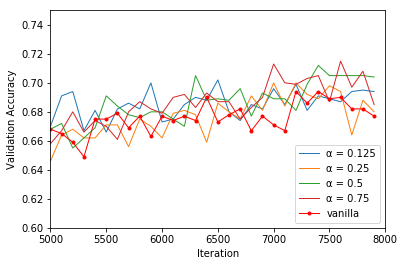

In [17]:
plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.plot(np.linspace(0, (len(vanilla_accs)-1)*print_every, len(vanilla_accs)), np.array(vanilla_accs), '-ro', lw=1, ms=3)
plt.xlim(5000, 8000)
plt.ylim(0.6, 0.75)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75', 'vanilla'], loc='lower right');

In [18]:
for ii in range(len(accs_list)):
    print('Max training accuracy for α = ' + str(alphas[ii]) + ": " + str(max(accs_list[ii])))
print('Max training accuracy for vanilla CNN: ' + str(max(vanilla_accs)))

Max training accuracy for α = 0.125: 0.702
Max training accuracy for α = 0.25: 0.7
Max training accuracy for α = 0.5: 0.712
Max training accuracy for α = 0.75: 0.715
Max training accuracy for vanilla CNN: 0.694


In [20]:
print("-----------------------------------------")
print("Vanilla CNN: ")
check_accuracy(loader_test, vanilla_model)
for alpha, model in octconv_model_dict.items():
    print("-----------------------------------------")
    print("α = " + str(alpha))
    check_accuracy(loader_test, model)

-----------------------------------------
Vanilla CNN: 
Checking accuracy on test set
Got 6783 / 10000 correct (67.83)
-----------------------------------------
α = 0.125
Checking accuracy on test set
Got 6990 / 10000 correct (69.90)
-----------------------------------------
α = 0.25
Checking accuracy on test set
Got 6918 / 10000 correct (69.18)
-----------------------------------------
α = 0.5
Checking accuracy on test set
Got 6898 / 10000 correct (68.98)
-----------------------------------------
α = 0.75
Checking accuracy on test set
Got 6903 / 10000 correct (69.03)
